In [ ]:
!pip install spotipy

     |████████████████████████████████| 153kB 22.2MB/s 
     |████████████████████████████████| 61kB 8.4MB/s 
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
import argparse
import pprint
import sys
import os
import subprocess
import json
import spotipy
import pathlib
import spotipy.util as util
import pandas as pd


from spotipy.oauth2 import SpotifyClientCredentials
from os import listdir

## **Obtenemos los datos**

In [ ]:
def get_playlist_content(username, playlist_id, sp):
    offset = 0
    songs = []
    while True:
        content = sp.user_playlist_tracks(username, playlist_id, fields=None,
                                          limit=100, offset=offset, market=None)
        songs += content['items']
        if content['next'] is not None:
            offset += 100
        else:
            break

    with open('{}-{}'.format(username, playlist_id), 'w') as outfile:
        json.dump(songs, outfile)


In [ ]:
def get_playlist_audio_features(username, playlist_id, nuestro_artist, sp):
    offset = 0
    songs = []
    items = []
    ids = []
    while True:
        content = sp.user_playlist_tracks(username, playlist_id, fields=None, limit=100, offset=offset, market=None)
        songs += content['items']
        if content['next'] is not None:
            offset += 100
        else:
            break

    artist_name = []
    songs_name = []
    for i in songs:
        ids.append(i['track']['id'])
        # artist_name.append(i['track']['artists'][0]['name'])
        songs_name.append(i['track']['name'])

    index = 0
    audio_features = []
    while index < len(ids):
        audio_features += sp.audio_features(ids[index:index + 50])
        index += 50

    features_list = []
    for features in audio_features:
        features_list.append([features['energy'], features['liveness'],
                              features['tempo'], features['speechiness'],
                              features['acousticness'], features['instrumentalness'],
                              features['time_signature'], features['danceability'],
                              features['key'], features['duration_ms'],
                              features['loudness'], features['valence'],
                              features['mode'], features['type'],
                              features['uri']])

    df = pd.DataFrame(features_list, columns=['energy', 'liveness',
                                                                    'tempo', 'speechiness', 
                                                                    'acousticness', 'instrumentalness',
                                                                    'time_signature', 'danceability',
                                                                    'key', 'duration_ms', 'loudness',
                                                                    'valence', 'mode', 'type', 'uri'])
    lista_artista = [nuestro_artist for i in range(len(songs_name))]
    df.insert(0,"artist",lista_artista,True)
    df.insert(1,"song",songs_name,True)

    df.to_csv('{}-{}.csv'.format(username, playlist_id), index=False)



def main(username, playlist, nuestro_artist):
    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
    print( "Getting playlist content")
    get_playlist_content(username, playlist, sp)
    print("Getting playlist audio features")
    get_playlist_audio_features(username, playlist, nuestro_artist, sp)


In [ ]:
#Leemos nuestras credenciales para poder usar la API de Spotify

with open("/content/drive/MyDrive/keys.json", "r") as input_file:
   dic_keys = json.load(input_file)

client_id = dic_keys["client_id"]
client_secret = dic_keys["client_secret"]
username = "2ql9bsmyz567swo4h3xmq0deg"


**Nos descargamos las playlist especificas de 7 cantantes diferentes para poder formar el dataset con el que entrenaremos nuestro modelo**

In [ ]:
client_credentials_manager = SpotifyClientCredentials(client_id, client_secret)

#C Tangana 
playlist_id ="37i9dQZF1DX1BjmS9srfRd"
main(username, playlist_id, "C Tangana")

Getting playlist content
Getting playlist audio features


In [ ]:
#Melendi 
playlist_id ="37i9dQZF1DWVTQhhSbm22P"

main(username, playlist_id, "Melendi")

Getting playlist content
Getting playlist audio features


In [ ]:
#Justin
playlist_id ="37i9dQZF1DXc2aPBXGmXrt"

main(username, playlist_id, "Justin")

Getting playlist content
Getting playlist audio features


In [ ]:
#Shawn
playlist_id ="37i9dQZF1DX5U6fr1hAMvg"

main(username, playlist_id, "Shawn")

Getting playlist content
Getting playlist audio features


In [ ]:
#Rosalia
playlist_id ="37i9dQZF1DXbjiU2ByCldP"

main(username, playlist_id, "Rosalia")

Getting playlist content
Getting playlist audio features


In [ ]:
#Fedez 
playlist_id ="37i9dQZF1DWYF0TmzCArBJ"

main(username, playlist_id, "Fedez")

Getting playlist content
Getting playlist audio features


In [ ]:
#Alboran
playlist_id ="37i9dQZF1DWYywdraylOvQ"

main(username, playlist_id, "Alboran")

Getting playlist content
Getting playlist audio features


In [ ]:
#Almacenamos la informacion de las playlist que hemos descargado en un csv a un dataframe
df = pd.DataFrame()

for file in listdir("/content/"):
  path = pathlib.Path(file)
  
  if (path.suffixes == [".csv"]):
    df = pd.concat([df, pd.read_csv(file)])



## **Entrenamiento de la Red Neuronal**

In [ ]:
# feature extractoring and preprocessing data
import librosa
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
import pathlib
import numpy as np

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

#Keras
import keras

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Encoding
genre_list = df.iloc[:, 0] #-1
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)

In [ ]:
df

,artist,song,energy,liveness,tempo,speechiness,acousticness,instrumentalness,time_signature,danceability,key,duration_ms,loudness,valence,mode,type,uri
0,Rosalia,Lo Vas A Olvidar (with ROSALÍA),0.248,0.0675,111.117,0.0798,0.71800,0.002460,5,0.351,4,203464,-14.653,0.0320,0,audio_features,spotify:track:0jagsVVkxwxhmTIicnOaon
1,Rosalia,MALAMENTE - Cap.1: Augurio,0.483,0.0737,98.057,0.0881,0.56500,0.013700,4,0.895,5,149450,-4.709,0.5200,0,audio_features,spotify:track:5zOAudPQIs5U8zP6LQGHmH
2,Rosalia,"Yo x Ti, Tu x Mi",0.759,0.1430,91.952,0.2250,0.46200,0.000868,4,0.780,1,201040,-3.292,0.5790,1,audio_features,spotify:track:7BlBVFwvbWvcwNcUarQmjk
3,Rosalia,DI MI NOMBRE - Cap.8: Éxtasis,0.535,0.2990,91.893,0.1230,0.86900,0.000083,4,0.794,8,162373,-6.371,0.5590,0,audio_features,spotify:track:56lQ8hCfzGmLtr14y9Wv6v
4,Rosalia,Con Altura,0.689,0.0501,97.963,0.1240,0.39000,0.003250,4,0.882,6,161627,-4.027,0.7460,1,audio_features,spotify:track:2qG5sZ7Si6sdK74qLxedYM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,C Tangana,Good Vibes - Official Remix,0.614,0.3080,99.923,0.1700,0.05440,0.000002,4,0.705,4,235720,-6.053,0.2580,0,audio_features,spotify:track:3I52e5l6ag02nA7UllFdM2
74,C Tangana,Voy Solo,0.746,0.1130,166.138,0.1250,0.45100,0.000179,4,0.672,1,201096,-8.280,0.7130,0,audio_features,spotify:track:3knXgaNIrA9QdIFIm0Jke9
75,C Tangana,Qué Pasará,0.416,0.1690,116.249,0.5450,0.00850,0.139000,3,0.564,7,202410,-10.690,0.3390,0,audio_features,spotify:track:4PgjeSsfc7PudNpy8aCims
76,C Tangana,La Última Generación,0.774,0.1070,130.042,0.0399,0.00105,0.128000,4,0.666,0,267186,-7.776,0.0657,1,audio_features,spotify:track:5C0VcNG8DEO7vVlV3DprlK


In [ ]:
features = df.drop(['artist','song','type','uri'],axis=1)

#scaling feautures
scaler = StandardScaler()
X = scaler.fit_transform(np.array(features, dtype = float))  #-1

In [ ]:
#Dividimos los datos en training y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
#Clasificando con Keras
from keras import models
from keras import layers
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

In [ ]:
model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.BatchNormalization())
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.BatchNormalization())
model.add(layers.Dense(7, activation='softmax'))

In [ ]:
my_optim = Adam(lr = 1e-5)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
callback = EarlyStopping(
    monitor = "val_accuracy", patience = 30, mode = "auto",
    restore_best_weights = True)

In [ ]:
history = model.fit(X_train,
                    y_train,
                    epochs=500,
                    batch_size=8, 
                    callbacks = [callback], 
                    validation_data=(X_test, y_test))

Epoch 1/500
43/43 [==============================] - 1s 8ms/step - loss: 2.4106 - accuracy: 0.1257 - val_loss: 1.9433 - val_accuracy: 0.2093
Epoch 2/500
43/43 [==============================] - 0s 3ms/step - loss: 2.2131 - accuracy: 0.1787 - val_loss: 1.9284 - val_accuracy: 0.2093
Epoch 3/500
43/43 [==============================] - 0s 3ms/step - loss: 2.0322 - accuracy: 0.2186 - val_loss: 1.9017 - val_accuracy: 0.2209
Epoch 4/500
43/43 [==============================] - 0s 3ms/step - loss: 1.9225 - accuracy: 0.2393 - val_loss: 1.8857 - val_accuracy: 0.2209
Epoch 5/500
43/43 [==============================] - 0s 4ms/step - loss: 1.8078 - accuracy: 0.3058 - val_loss: 1.8556 - val_accuracy: 0.2674
Epoch 6/500
43/43 [==============================] - 0s 3ms/step - loss: 1.7659 - accuracy: 0.2982 - val_loss: 1.8653 - val_accuracy: 0.2558
Epoch 7/500
43/43 [==============================] - 0s 3ms/step - loss: 1.7789 - accuracy: 0.3158 - val_loss: 1.8619 - val_accuracy: 0.2558
Epoch 8/500
4

In [ ]:
test_loss, test_acc = model.evaluate(X_test,y_test)
print('test_acc: ',test_acc)

3/3 [==============================] - 0s 4ms/step - loss: 1.6467 - accuracy: 0.4070
test_acc:  0.40697672963142395


## **Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

In [ ]:

param_grid = {
    "max_depth" : [5, 10, 20, 30, 50],
    "n_estimators"   : [500, 1000, 2000, 5000, 10000],
    "min_samples_split" : [2, 5, 10],
    "min_samples_leaf" : [1, 2, 4]
}
param_grid

{'max_depth': [5, 10, 20, 30, 50],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [500, 1000, 2000, 5000, 10000]}

In [ ]:
all_params = [dict(zip(param_grid.keys(),v)) for v in itertools.product(*param_grid.values())]
len(all_params)

225

In [ ]:
import itertools
import pandas as pd
import numpy as np
import seaborn as sns
from csv import DictWriter
from tqdm.notebook import tqdm

In [ ]:
v_acc = []

# cuenta = 0

field_names = ['max_depth','n_estimators','min_samples_split','min_samples_leaf', 'v_acc']

for params in tqdm(all_params):    
    # cuenta += 1
    
    # print(f"********** Iteracion {cuenta} de {len(all_params)} ************")
    
    clf = RandomForestClassifier(**params)
    clf.fit(X_train, y_train)
    res = clf.predict(X_test)
    params['v_acc'] = (res==y_test).sum()/len(res)
    
    
    
    with open('DNE/tuning_results.csv', 'a') as f_object:

        # Pass the file object and a list 
        # of column names to DictWriter()
        # You will get a object of DictWriter
        dictwriter_object = DictWriter(f_object, fieldnames=field_names)

        #Pass the dictionary as an argument to the Writerow()
        dictwriter_object.writerow(params)

        #Close the file object
        f_object.close()

### **Results**

In [ ]:
df = pd.read_csv("DNE/tuning_results.csv", sep=",", names = ['max_depth','n_estimators','min_samples_split','min_samples_leaf', 'v_acc'], skip_blank_lines=True)
df

,max_depth,n_estimators,min_samples_split,min_samples_leaf,v_acc
0,2,500,2,1,0.418605
1,2,500,2,2,0.453488
2,2,500,2,4,0.453488
3,2,500,5,1,0.453488
4,2,500,5,2,0.406977
...,...,...,...,...,...
220,30,10000,5,2,0.476744
221,30,10000,5,4,0.476744
222,30,10000,10,1,0.476744
223,30,10000,10,2,0.476744


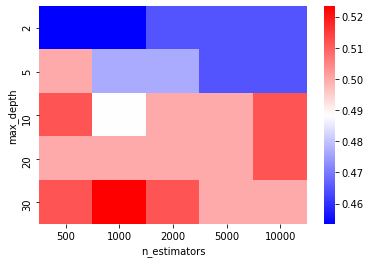

In [ ]:
df2 = df.groupby(['max_depth', 'n_estimators']).max().reset_index()
pivot = df2.pivot('max_depth', 'n_estimators', 'v_acc')
ax = sns.heatmap(pivot.fillna(np.min(pivot)), cmap="bwr")

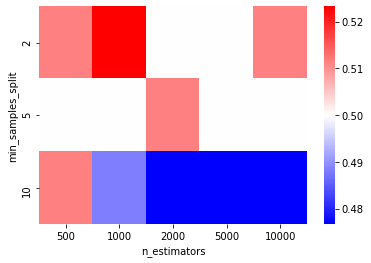

In [ ]:
df2 = df.groupby(['min_samples_split', 'n_estimators']).max().reset_index()
pivot = df2.pivot('min_samples_split', 'n_estimators', 'v_acc')
ax = sns.heatmap(pivot.fillna(np.min(pivot)), cmap="bwr")

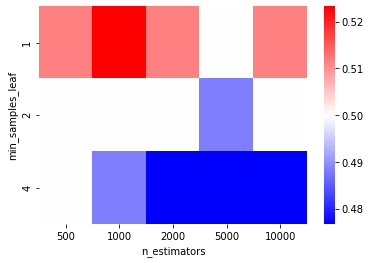

In [ ]:
df2 = df.groupby(['min_samples_leaf', 'n_estimators']).max().reset_index()
pivot = df2.pivot('min_samples_leaf', 'n_estimators', 'v_acc')
ax = sns.heatmap(pivot.fillna(np.min(pivot)), cmap="bwr")

## **Second tuning with better params range**

In [ ]:
param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth" : np.arange(30, 50, 1),
    "n_estimators"   : np.arange(500, 1500, 100),
    "min_samples_split" : [0.5, 0.75, 1.0, 2],
    "min_samples_leaf" : [1],
}
param_grid
all_params = [dict(zip(param_grid.keys(),v)) for v in itertools.product(*param_grid.values())]
len(all_params)

1600

In [ ]:
v_acc = []

# cuenta = 0

field_names = ['criterion', 'max_depth','n_estimators','min_samples_split','min_samples_leaf', 'v_acc']

for params in tqdm(all_params):    
    # cuenta += 1
    
    # print(f"********** Iteracion {cuenta} de {len(all_params)} ************")
    
    clf = RandomForestClassifier(**params)
    clf.fit(X_train, y_train)
    res = clf.predict(X_test)
    params['v_acc'] = (res==y_test).sum()/len(res)
    
    
    
    with open('DNE/better_tuning_results.csv', 'a') as f_object:

        # Pass the file object and a list 
        # of column names to DictWriter()
        # You will get a object of DictWriter
        dictwriter_object = DictWriter(f_object, fieldnames=field_names)

        #Pass the dictionary as an argument to the Writerow()
        dictwriter_object.writerow(params)

        #Close the file object
        f_object.close()

In [ ]:
df = pd.read_csv("DNE/better_tuning_results.csv", sep=",", names = ['criterion', 'max_depth','n_estimators','min_samples_split','min_samples_leaf', 'v_acc'], skip_blank_lines=True)
df

,criterion,max_depth,n_estimators,min_samples_split,min_samples_leaf,v_acc
0,gini,30,500,0.50,1,0.395349
1,gini,30,500,0.75,1,0.139535
2,gini,30,500,1.00,1,0.139535
3,gini,30,500,2.00,1,0.500000
4,gini,30,600,0.50,1,0.383721
...,...,...,...,...,...,...
1600,entropy,49,1300,2.00,1,0.534884
1601,entropy,49,1400,0.50,1,0.372093
1602,entropy,49,1400,0.75,1,0.139535
1603,entropy,49,1400,1.00,1,0.139535


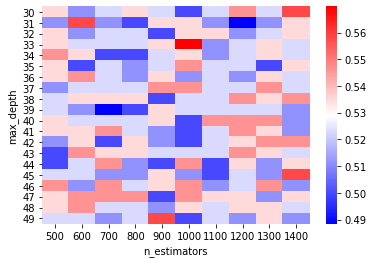

In [ ]:
df2 = df.groupby(['max_depth', 'n_estimators']).max().reset_index()
pivot = df2.pivot('max_depth', 'n_estimators', 'v_acc')
ax = sns.heatmap(pivot.fillna(np.min(pivot)), cmap="bwr")


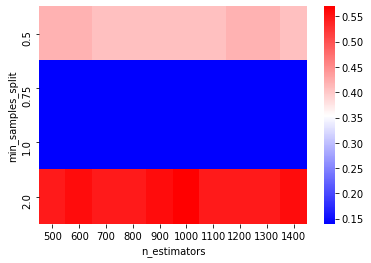

In [ ]:
df2 = df.groupby(['min_samples_split', 'n_estimators']).max().reset_index()
pivot = df2.pivot('min_samples_split', 'n_estimators', 'v_acc')
ax = sns.heatmap(pivot.fillna(np.min(pivot)), cmap="bwr")

In [ ]:
ax = sns.boxplot(x="criterion", y="v_acc", data=df)

In [ ]:
print(df.sort_values(by="v_acc", ascending=False).iloc[0])

In [ ]:
from google.colab import files
files.download("/DNE")